In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Iako slike kad se pogledaju izgledaju kao da su crno bele nece tako biti ucitane
# pa moramo da pored standardnog pretvaranja u Tensor, pretvorimo i u greyscale da bismo sveli samo na jedan kanal.
loading_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [3]:
#load the data
train_dataset       = datasets.ImageFolder(root='../data/Training', transform=loading_transform) 
validation_dataset  = datasets.ImageFolder(root='../data/Validation', transform=loading_transform)
test_dataset        = datasets.ImageFolder(root='../data/Test', transform=loading_transform)

In [4]:
print(f"Training dataset size:      {len(train_dataset)} instances")
print(f"Validation dataset size:    {len(validation_dataset)} instances")
print(f"Test dataset size:          {len(test_dataset)} instances")

Training dataset size:      28709 instances
Validation dataset size:    3589 instances
Test dataset size:          3589 instances


In [5]:
# Make dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [6]:
img, label = train_dataset[0]

In [7]:
img.shape

torch.Size([1, 48, 48])

In [8]:
import torch.nn.functional as F
from torch import nn
import torch

In [9]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super().__init__()
        

        self.dense1 = nn.Linear(2304,128)
        self.dense2 = nn.Linear(128, 64)
        self.dense3 = nn.Linear(64,32)
        self.final = nn.Linear(32,7)
        
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        
        x = self.flatten(x)

        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.relu(self.dense3(x))
        x = self.final(x)

        return x

In [10]:
class simpleConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.layer1 = nn.Conv2d(1,32,3) 
                                        
        self.layer2 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.final_layer = nn.Linear(6400,7)

    def forward(self, x):

        x = F.relu(self.layer1(x))
        x = self.pool(x)

        x = F.relu(self.layer2(x))
        x = self.pool(x)

        x = self.flatten(x)
        return self.final_layer(x)

In [11]:
class EmotionNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # The input size for fc1 is now adjusted for 48x48 images after 3 conv + pool layers
        # Input size to fc1: 128 filters * (48 / 2 / 2 / 2)^2 = 128 * 6 * 6 = 4608
        self.fc1 = nn.Linear(in_features=128 * 6 * 6, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

        self.flatten = nn.Flatten(start_dim=1)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))

        x = self.pool(F.relu(self.conv3(x)))

        x = self.flatten(x)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [30]:
class EDA_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.layer1 = nn.Conv2d(1,32,3) 
                                        
        self.layer2 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.dense1 = nn.Linear(6400,64)
        self.dense2 = nn.Linear(64,7)

    def forward(self, x):

        x = F.relu(self.layer1(x))
        x = self.pool(x)

        x = F.relu(self.layer2(x))
        x = self.pool(x)

        x = self.flatten(x)
        
        x = F.relu(self.dense1(x))
        x = F.softmax(self.dense2(x))
        return x

In [13]:
scn = simpleConvNet()

In [14]:
scn(img.reshape(1,1,48,48))

tensor([[-0.1281,  0.1218, -0.0239, -0.0333, -0.0327,  0.0858,  0.0363]],
       grad_fn=<AddmmBackward0>)

In [ ]:
emoNet = EmotionNet()

In [16]:
emoNet(img.reshape(1,1,48,48))

tensor([[ 0.0135,  0.0553, -0.0195, -0.0298, -0.0590, -0.0029,  0.0191]],
       grad_fn=<AddmmBackward0>)

In [32]:
eda_cnn = EDA_CNN()

In [33]:
eda_cnn(img.reshape(1,1,48,48))

/tmp/ipykernel_21896/3233798655.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.dense2(x))


tensor([[0.1340, 0.1469, 0.1344, 0.1513, 0.1479, 0.1443, 0.1413]],
       grad_fn=<SoftmaxBackward0>)

In [10]:
fcnn = FullyConnectedNN()

In [11]:
fcnn(img.reshape(1,1,48,48))

tensor([[ 0.1081, -0.2020,  0.0761,  0.0760, -0.0046, -0.1569,  0.1836]],
       grad_fn=<AddmmBackward0>)

In [12]:
label

0

In [13]:
from torch import optim

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

In [24]:
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer, device):
    model.train()
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        preds = model(X)
        loss = loss_fn(preds, y)

        #radimo backpropagation - racunamo gradijente
        loss.backward()

        #ovde radimo X_new = x - lr * grad
        optimizer.step()

        #ne zelimo da sabiramo sve gradijente zato ih ponistimo posle svake iteracije
        optimizer.zero_grad()

In [25]:
def test_loop(dataloader: DataLoader, model: nn.Module, loss_fn, device):
    # moramo da naglasimo da testiramo
    model.eval()
    with torch.no_grad():
        # racunamo total loss i broj pogodjenih predvidjanja
        total_loss = 0
        num_same = 0

        #idemo kroz loader i provlacimo instance kroz model i dobijemo predikciju
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            _, indices = torch.max(outputs,1)
            num_same += sum(indices == y).item()
        
        print(total_loss)
        print(num_same / len(dataloader.dataset))


In [26]:
# num_epochs = 2
# optimizer = optim.Adam(params=fcnn.parameters(), lr=0.001)
# fcnn.to(device)
# for epoch in range(num_epochs):
#     train_loop(train_dataloader, model=fcnn,loss_fn=loss_fn,optimizer=optimizer,device=device)
#     test_loop(test_dataloader, model=fcnn,loss_fn=loss_fn, device=device)

In [27]:
# num_epochs = 2
# optimizer = optim.Adam(params=scn.parameters(), lr=0.001)
# scn.to(device)
# for epoch in range(num_epochs):
#     train_loop(train_dataloader, model=scn,loss_fn=loss_fn,optimizer=optimizer,device=device)
#     test_loop(validation_dataloader, model=scn,loss_fn=loss_fn, device=device)

In [28]:
# num_epochs = 2
# optimizer = optim.Adam(params=emoNet.parameters(), lr=0.0001)
# emoNet.to(device)
# for epoch in range(num_epochs):
#     train_loop(train_dataloader, model=emoNet,loss_fn=loss_fn,optimizer=optimizer,device=device)
#     test_loop(validation_dataloader, model=emoNet,loss_fn=loss_fn, device=device)

In [29]:
# num_epochs = 2
# optimizer = optim.Adam(params=eda_cnn.parameters(), lr=0.0001)
# eda_cnn.to(device)
# for epoch in range(num_epochs):
#     train_loop(train_dataloader, model=eda_cnn,loss_fn=loss_fn,optimizer=optimizer,device=device)
#     test_loop(validation_dataloader, model=eda_cnn,loss_fn=loss_fn, device=device)

In [15]:
test_img, test_label = test_dataset[2000]

In [16]:
print(test_img.shape)
print(test_label)

torch.Size([1, 48, 48])
4


In [32]:
scn(test_img.reshape(1,1,48,48))

tensor([[-0.1699,  0.1314, -0.0520, -0.0629, -0.0500,  0.0928,  0.0166]],
       grad_fn=<AddmmBackward0>)

In [33]:
emoNet(test_img.reshape(1,1,48,48))

tensor([[ 0.0200,  0.0386, -0.0708, -0.0273, -0.0667, -0.0275, -0.0219]],
       grad_fn=<AddmmBackward0>)

In [34]:
eda_cnn(test_img.reshape(1,1,48,48))

/tmp/ipykernel_21896/3233798655.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.dense2(x))


tensor([[0.1344, 0.1456, 0.1328, 0.1526, 0.1489, 0.1451, 0.1406]],
       grad_fn=<SoftmaxBackward0>)

In [35]:
import os

In [17]:
import numpy as np

In [18]:
losses = np.arange(1, 5+1, 1)
print(losses)

[1 2 3 4 5]


In [19]:
import function_lib as flib

In [40]:
losses = []
accs = []

optimizer = optim.Adam(params=emoNet.parameters(), lr=0.001)

(losses, accs) = flib.train(emoNet, train_dataloader, validation_dataloader, loss_fn,optimizer, losses=losses, accs=accs,num_epochs=10)

Training epoch: 1...
Total loss: 166.19218564033508
Accuracy: 0.4388409027584285
Training epoch: 2...
Total loss: 151.39646422863007
Accuracy: 0.4848147116188353
Training epoch: 3...
Total loss: 142.96685922145844
Accuracy: 0.5160211758149903
Training epoch: 4...
Total loss: 135.79350411891937
Accuracy: 0.5338534410699359
Training epoch: 5...
Total loss: 133.2561390399933
Accuracy: 0.5528002229033157
Training epoch: 6...
Total loss: 131.56198143959045
Accuracy: 0.5539147394817497
Training epoch: 7...
Total loss: 132.30738359689713
Accuracy: 0.5611590972415714
Training epoch: 8...
Total loss: 132.10880291461945
Accuracy: 0.5628308721092227
Training epoch: 9...
Total loss: 134.3241617679596
Accuracy: 0.571468375592087
Training epoch: 10...
Total loss: 137.42241030931473
Accuracy: 0.571468375592087


In [41]:
flib.print_trainable_params(emoNet)

Total number of trainable parameters: 2456071


In [42]:
losses

[166.19218564033508,
 151.39646422863007,
 142.96685922145844,
 135.79350411891937,
 133.2561390399933,
 131.56198143959045,
 132.30738359689713,
 132.10880291461945,
 134.3241617679596,
 137.42241030931473]

In [43]:
flib.save_model(model=emoNet, model_name="emoNet",path="../models")

models directory already exists
Saving model...
Model 'emoNet' saved successfully.


In [44]:
pred = emoNet(test_img.reshape(1,1,48,48))
result = pred.detach().cpu().numpy()[0]
print(result)
print(np.argmax(result))

[ 1.0756075  -1.3899382   1.5527766  -3.315274   -1.0769839   0.28350645
 -2.9202287 ]
2


In [45]:
test_label

4

In [23]:
from matplotlib import pyplot as plt

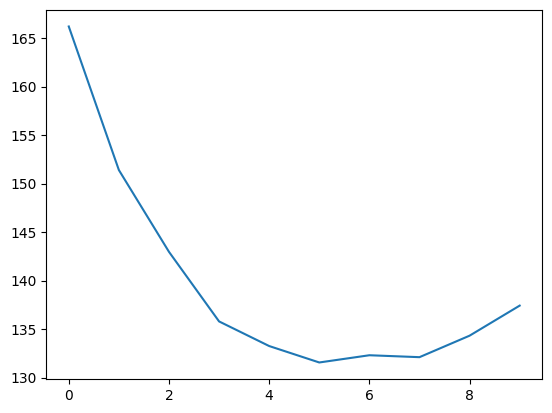

In [47]:
plt.plot(range(len(losses)), losses)
plt.show()

In [48]:
losses = []
accs = []

optimizer = optim.Adam(params=scn.parameters(), lr=0.001)

(losses, accs) = flib.train(scn, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, loss_fn=loss_fn, optimizer=optimizer, losses=losses, accs=accs,num_epochs=10)
flib.save_model(model=scn, model_name="simpleConvNN",path="../models")

Training epoch: 1...
Total loss: 167.16958510875702
Accuracy: 0.4354973530231262
Training epoch: 2...
Total loss: 155.8980546593666
Accuracy: 0.4672610755084982
Training epoch: 3...
Total loss: 151.2067093849182
Accuracy: 0.48843689049874617
Training epoch: 4...
Total loss: 149.2838940024376
Accuracy: 0.4887155196433547
Training epoch: 5...
Total loss: 149.742546916008
Accuracy: 0.49707439398161046
Training epoch: 6...
Total loss: 148.8530237674713
Accuracy: 0.4990247979938702
Training epoch: 7...
Total loss: 148.0495042204857
Accuracy: 0.5082195597659516
Training epoch: 8...
Total loss: 148.97117894887924
Accuracy: 0.5084981889105601
Training epoch: 9...
Total loss: 149.36548054218292
Accuracy: 0.507940930621343
Training epoch: 10...
Total loss: 148.4755960702896
Accuracy: 0.5268877124547228
models directory already exists
Saving model...
Model 'simpleConvNN' saved successfully.


In [49]:
flib.print_trainable_params(scn)

Total number of trainable parameters: 63623


[ 3.7111856e-02 -3.9962823e+00 -5.6346007e-02 -1.8722268e+00
  1.7225151e-01 -1.7609298e-03 -5.9939375e+00]
4


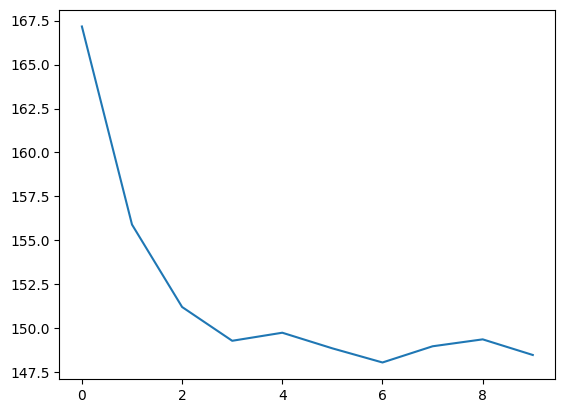

In [50]:
pred = scn(test_img.reshape(1,1,48,48))
result = pred.detach().cpu().numpy()[0]
print(result)
print(np.argmax(result))

plt.plot(range(len(losses)), losses)
plt.show()

In [35]:
losses = []
accs = []

optimizer = optim.Adam(params=eda_cnn.parameters(), lr=0.001)

(losses, accs) = flib.train(eda_cnn, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, loss_fn=loss_fn, optimizer=optimizer, losses=losses, accs=accs,num_epochs=10)
flib.save_model(model=eda_cnn, model_name="EDA_CNN",path="../models")

Training epoch: 1...


/tmp/ipykernel_21896/3233798655.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.dense2(x))


Total loss: 199.68835306167603
Accuracy: 0.3867372527166342
Training epoch: 2...
Total loss: 196.306987285614
Accuracy: 0.4204513792142658
Training epoch: 3...
Total loss: 192.62335062026978
Accuracy: 0.454444134856506
Training epoch: 4...
Total loss: 191.32999193668365
Accuracy: 0.4664251880746726
Training epoch: 5...
Total loss: 189.80741727352142
Accuracy: 0.48063527444970744
Training epoch: 6...
Total loss: 188.98714995384216
Accuracy: 0.4845360824742268
Training epoch: 7...
Total loss: 189.0220170021057
Accuracy: 0.4811925327389245
Training epoch: 8...
Total loss: 187.5562995672226
Accuracy: 0.5004179437169128
Training epoch: 9...
Total loss: 187.32203769683838
Accuracy: 0.4962385065477849
Training epoch: 10...
Total loss: 188.28480398654938
Accuracy: 0.4948453608247423
models directory already exists
Saving model...
Model 'EDA_CNN' saved successfully.


In [52]:
flib.print_trainable_params(eda_cnn)

Total number of trainable parameters: 428935


[1.0492153e-06 5.9633149e-12 5.2720396e-04 5.9967792e-01 3.8614959e-01
 1.3644253e-02 1.8749383e-15]
3


/tmp/ipykernel_166215/3233798655.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.dense2(x))


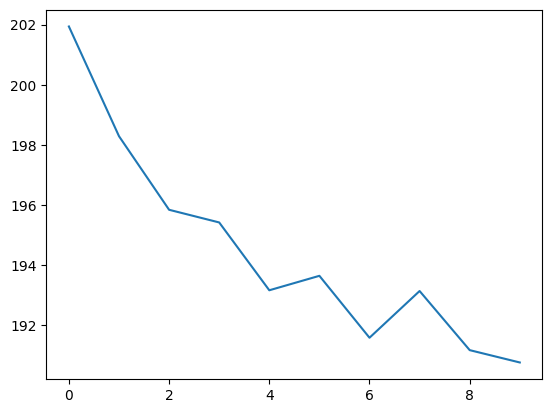

In [53]:
pred = eda_cnn(test_img.reshape(1,1,48,48))
result = pred.detach().cpu().numpy()[0]
print(result)
print(np.argmax(result))

plt.plot(range(len(losses)), losses)
plt.show()

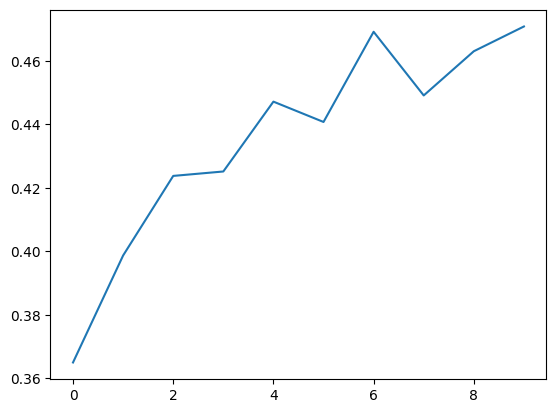

In [54]:
plt.plot(range(len(losses)), accs)
plt.show()

In [26]:
losses = []
accs = []

optimizer = optim.Adam(params=fcnn.parameters(), lr=0.001)

(losses, accs) = flib.train(fcnn, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, loss_fn=loss_fn, optimizer=optimizer, losses=losses, accs=accs,num_epochs=10)
flib.save_model(model=fcnn, model_name="fullyConnectedNN",path="../models")

Training epoch: 1...
Total loss: 178.25541508197784
Accuracy: 0.3895235441627194
Training epoch: 2...
Total loss: 176.2840975522995
Accuracy: 0.38450821955976594
Training epoch: 3...
Total loss: 178.68271780014038
Accuracy: 0.3764279743661187
Training epoch: 4...
Total loss: 176.46616423130035
Accuracy: 0.39063806074115354
Training epoch: 5...
Total loss: 176.70081049203873
Accuracy: 0.38144329896907214
Training epoch: 6...
Total loss: 177.3180594444275
Accuracy: 0.38200055725828924
Training epoch: 7...
Total loss: 175.8508871793747
Accuracy: 0.39648927277793256
Training epoch: 8...
Total loss: 174.00077140331268
Accuracy: 0.4028977431039287
Training epoch: 9...
Total loss: 174.75618267059326
Accuracy: 0.40596266369462247
Training epoch: 10...
Total loss: 180.1141858100891
Accuracy: 0.390359431596545
models directory already exists
Saving model...
Model 'fullyConnectedNN' saved successfully.


In [27]:
flib.print_trainable_params(fcnn)

Total number of trainable parameters: 305607


[ 1.5729088  -1.2877936   0.64457613  1.1248933   1.4241496   1.1180427
 -3.4957156 ]
0


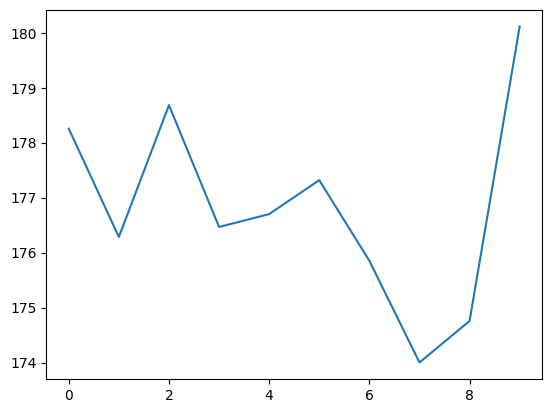

In [28]:
pred = fcnn(test_img.reshape(1,1,48,48))
result = pred.detach().cpu().numpy()[0]
print(result)
print(np.argmax(result))

plt.plot(range(len(losses)), losses)
plt.show()

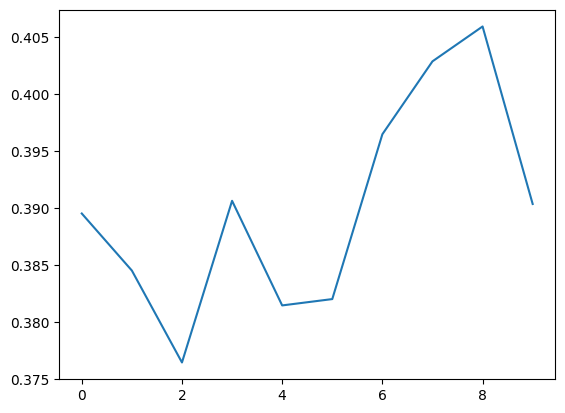

In [29]:
plt.plot(range(len(losses)), accs)
plt.show()